In [1]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from datetime import datetime
import random
import matplotlib.pyplot as plt
import requests

In [2]:
def proba_data(real,pred,step):
    y = []
    x = []
    i = 0
    while i < len(real):
        ones = len(pred[(pred < i + step) & (pred >= i) & (real == 1)])
        all = len(pred[(pred < i + step) & (pred >= i)])
        if all == 0:
            break
        y.append(ones / all)
        x.append(i + (step / 2))
        i += step
    return x,y

In [3]:
df1 = pd.read_excel('BLUSOL/CLIENTES BLUSOL 2019.xlsx')
df2 = pd.read_excel('BLUSOL/CLIENTES BLUSOL 2020.xlsx')
df3 = pd.read_excel('BLUSOL/CLIENTES BLUSOL 2021 A 2023.xlsx')
df4 = pd.read_excel('BancoEmpreendedor/CLIENTES BE 2019 A 2023.xlsx')
df5 = pd.read_excel('crecerto/CLIENTES CRECERTO 2019 A 2023.xlsx')
print(len(df1),len(df2),len(df3),len(df4),len(df5))
df = pd.concat([df1,df2,df3,df4,df5]).reset_index(drop = True)

11196 12823 24435 32437 31555


In [4]:
for i in range(3):
    cols = list(df.columns)
    res = [(a, b) for idx, a in enumerate(cols) for b in cols[idx + 1:]]
    deleted = set()
    for x,y in res:
        if (x in deleted) or (y in deleted):
            continue
        newx = x.replace('Nº','nro').replace('PF/PJ','pessoaFisicaJuridica').replace('Score','conceito').replace('Data conceito SPC','datadospc').replace('numero','nro').replace('Classificacao Empresa','classificacao')
        newy = y.replace('Nº','nro').replace('PF/PJ','pessoaFisicaJuridica').replace('Score','conceito').replace('Data conceito SPC','datadospc').replace('numero','nro').replace('Classificacao Empresa','classificacao')
        if newx.lower().replace(' ','') == newy.lower().replace(' ',''):
            new_col = df[x].fillna(df[y])
            del(df[x])
            deleted.add(x)
            del(df[y])
            deleted.add(y)
            df[newx.lower().replace(' ','')] = new_col

In [5]:
def corrigir_taxa(x):
    if x >= 1000000:
        return x / 100000000
    return x / 100

def valor_da_parcela(row):
    taxa = row['taxaaomes']
    vp = row['valoremprestado']
    n = row['quantidadeparcelas']
    if taxa == 0:
        return vp / n
    return vp * (taxa * ((1 + taxa) ** n)) / (((1 + taxa) ** n) - 1)

def renda(row):
    if pd.isnull(row['totaldasreceitas']):
        if pd.isnull(row['rendafamiliarmensal']):
            return 0
        return row['rendafamiliarmensal']
    if pd.isnull(row['rendafamiliarmensal']):
        return row['totaldasreceitas']
    return max(row['totaldasreceitas'],row['rendafamiliarmensal'])

In [6]:
df = df[df['situacaocredito'] != 'Estornado']
df = df[df['quantidadeparcelas'] != 0]
df = df[~df['primeirovencimento'].isna()]
df = df[~df['nroparcelaspagas'].isna()]
df['primeirovencimento'] = pd.to_datetime(df['primeirovencimento'])
df['ultimaparcelapaga'] = df['primeirovencimento'] + df['nroparcelaspagas'].apply(lambda x: relativedelta(months = x - 1))
today = datetime(2023,4,20)
df['diasdesdeultimaparcela'] = (today - df['ultimaparcelapaga']).apply(lambda x: x.days)
df['taxaaomes'] = df['taxaaomes'].apply(corrigir_taxa)
df['valorparcela'] = df.apply(valor_da_parcela,axis = 1)
df['renda'] = df.apply(renda,axis = 1)
df['pesoparcela'] = df['valorparcela'] / df['renda']
df['pesoparcela'] = df['pesoparcela'].apply(lambda x: 1 if x > 1 else x)
df['DEFAULT'] = (df['diasdesdeultimaparcela'] > 90) & (df['nroparcelaspagas'] != df['quantidadeparcelas'])
df = df.drop(['atividadeexercida','idcliente','nroparcelaspagas','primeirovencimento','tempoderesidenciaanos','valorparcela',
              'pesoparcela','tempodeatividade','tempoderesidenciameses','temporesidenciaimovel',
              'situacaocredito','ultimaparcelapaga','diasdesdeultimaparcela','renda',
              'dataemprestimo','dataliberacao','datacadastro','primeirovencimento','maioratrasopagas','CEP','bairro','cidade',
              'cepempresa','bairroempresa','cidadeempresa','datadospc','finalDoContrato','classificacao','produto'],axis = 1)
df = df.reset_index(drop = True)

C:\Users\aruav\AppData\Local\Temp\ipykernel_12740\655652845.py:6: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df['ultimaparcelapaga'] = df['primeirovencimento'] + df['nroparcelaspagas'].apply(lambda x: relativedelta(months = x - 1))


In [7]:
url = 'http://127.0.0.1:5000/'
secret = open('app_simples/admin_pass','r').read()

In [8]:
import time

In [26]:
df = df.drop(['temporesidenciaimovel'],axis = 1)

In [21]:
random_index = random.randint(0,len(df) - 1)
object = {col:df.loc[random_index,col] for col in df.drop('DEFAULT',axis = 1).columns}
object = {key:object[key] for key in object.keys() if not pd.isnull(object[key])}
req = requests.get(url,json = object,auth = ('deepen',secret))
req.json()

{'probabilidade': 0.1914598196406452}

In [27]:
chances = []
true_values = []
times = []
for i in range(10000):
    random_index = random.randint(0,len(df) - 1)
    true_values.append(df.loc[random_index,'DEFAULT'])
    object = {col:df.loc[random_index,col] for col in df.drop('DEFAULT',axis = 1).columns}
    object = {key:object[key] for key in object.keys() if not pd.isnull(object[key])}
    now = time.time()
    req = requests.get(url,json = object,auth = ('deepen',secret))
    times.append(time.time() - now)
    if req.status_code == 200:
        chance = req.json()['probabilidade']
        chances.append(chance)
    else:
        print(req.json())
        break

In [28]:
times = np.array(times)
print('mean:',times.mean())
print('std:',times.std())

mean: 0.007668318724632263
std: 0.0014492045630969182


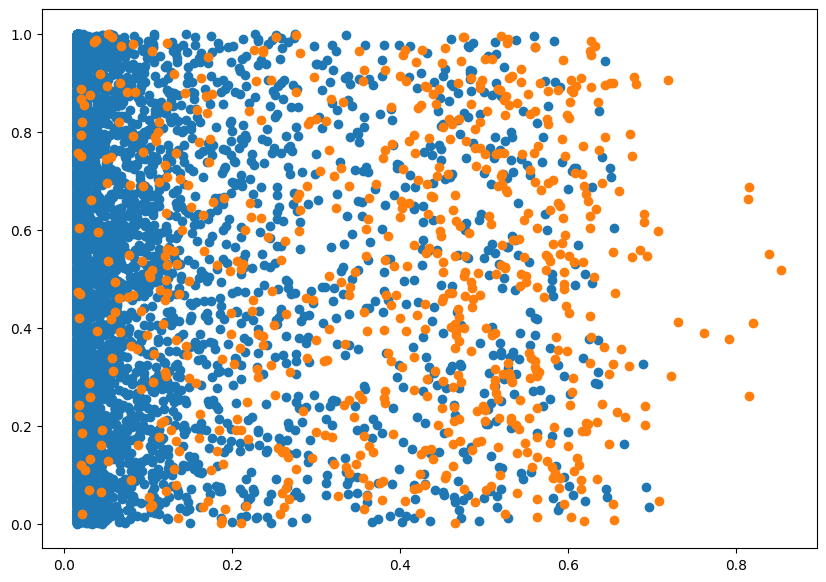

In [29]:
prediction = np.array(chances)
y_test = np.array(true_values)
plt.figure(figsize = (10,7))
_ = plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
_ = plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))

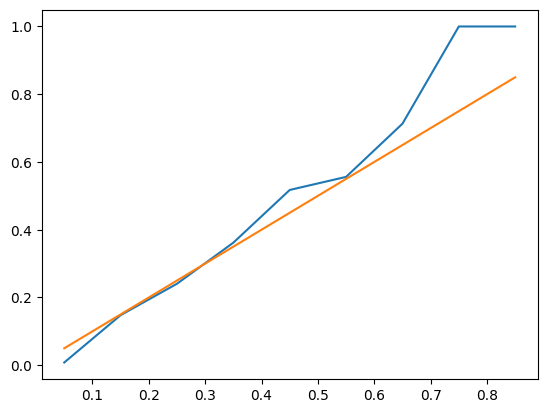

In [30]:
probx,proby = proba_data(y_test,prediction,0.1)
plt.plot(probx,proby)
plt.plot(probx,probx)
plt.show()